In [19]:
# Library Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
plt.style.use("ggplot")

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Loading/Reading in the Data
import yfinance as yf
data = yf.download('BTC-USD')
#df = pd.read_csv("BTC-USD.csv")

# Data Preprocessing
### Setting the datetime index as the date, only selecting the 'Close' column, then only the last 1000 closing prices.
#df = df.set_index("Date")[['Close']].tail(1000)
#df = df.set_index(pd.to_datetime(df.index))

# Normalizing/Scaling the Data
scaler = MinMaxScaler()
#df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

[*********************100%***********************]  1 of 1 completed


In [20]:
new_df = pd.DataFrame(data['Close']).set_index(pd.to_datetime(pd.DataFrame(data['Close']).index))
new_df = pd.DataFrame(scaler.fit_transform(new_df), columns=new_df.columns, index=new_df.index)

In [52]:
df = new_df[-2000:]

In [53]:
df.info

<bound method DataFrame.info of                Close
Date                
2015-04-02  0.003877
2015-04-03  0.003945
2015-04-04  0.003913
2015-04-05  0.004270
2015-04-06  0.004006
...              ...
2020-09-18  0.557292
2020-09-19  0.565044
2020-09-20  0.556965
2020-09-21  0.532326
2020-09-22  0.532474

[2000 rows x 1 columns]>

In [54]:
def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history
    plt.figure(figsize=(12,4))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(12,4))
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    
    
def split_sequence(seq, n_steps_in, n_steps_out):
    """
    Splits the univariate time sequence
    """
    X, y = [], []
    
    for i in range(len(seq)):
        end = i + n_steps_in
        out_end = end + n_steps_out
        
        if out_end > len(seq):
            break
        
        seq_x, seq_y = seq[i:end], seq[end:out_end]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)


def layer_maker(n_layers, n_nodes, activation, drop=None, d_rate=.5):
    """
    Create a specified number of hidden layers for an RNN
    Optional: Adds regularization option, dropout layer to prevent potential overfitting if necessary
    """
    
    # Creating the specified number of hidden layers with the specified number of nodes
    for x in range(1,n_layers+1):
        model.add(LSTM(n_nodes, activation=activation, return_sequences=True))

        # Adds a Dropout layer after every Nth hidden layer (the 'drop' variable)
        try:
            if x % drop == 0:
                model.add(Dropout(d_rate))
        except:
            pass

In [65]:
### How many periods looking back to train
n_per_in  = 1930

# How many periods ahead to predict
n_per_out = 10

# Features (in this case it's 1 because there is only one feature: price)
n_features = 1

# Splitting the data into appropriate sequences
X, y = split_sequence(list(df.Close), n_per_in, n_per_out)

# Reshaping the X variable from 2D to 3D
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [66]:
model = Sequential()

# Activation
activ = "softsign"

# Input layer
model.add(LSTM(30, activation=activ, return_sequences=True, input_shape=(n_per_in, n_features)))

# Hidden layers
layer_maker(n_layers=0, n_nodes=12, activation=activ)

# Final Hidden layer
model.add(LSTM(10, activation=activ))

# Output layer
model.add(Dense(n_per_out))

# Model summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 1930, 30)          3840      
_________________________________________________________________
lstm_10 (LSTM)               (None, 10)                1640      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                110       
Total params: 5,590
Trainable params: 5,590
Non-trainable params: 0
_________________________________________________________________


In [67]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [70]:
res = model.fit(X, y, epochs=50, batch_size=14, validation_split=0.2, use_multiprocessing=True)

Train on 48 samples, validate on 13 samples
Epoch 1/50
48/48 [==============================] - 6s 133ms/step - loss: 0.1233 - accuracy: 0.1042 - val_loss: 0.0890 - val_accuracy: 0.0769
Epoch 2/50
48/48 [==============================] - 6s 127ms/step - loss: 0.0996 - accuracy: 0.1042 - val_loss: 0.0742 - val_accuracy: 0.0769
Epoch 3/50
48/48 [==============================] - 6s 129ms/step - loss: 0.0817 - accuracy: 0.1042 - val_loss: 0.0651 - val_accuracy: 0.0769
Epoch 4/50
48/48 [==============================] - 6s 127ms/step - loss: 0.0686 - accuracy: 0.1042 - val_loss: 0.0548 - val_accuracy: 0.0769
Epoch 5/50
48/48 [==============================] - 6s 127ms/step - loss: 0.0551 - accuracy: 0.1042 - val_loss: 0.0412 - val_accuracy: 0.0769
Epoch 6/50
48/48 [==============================] - 6s 128ms/step - loss: 0.0418 - accuracy: 0.1042 - val_loss: 0.0292 - val_accuracy: 0.0769
Epoch 7/50
48/48 [==============================] - 6s 126ms/step - loss: 0.0313 - accuracy: 0.1042 - va

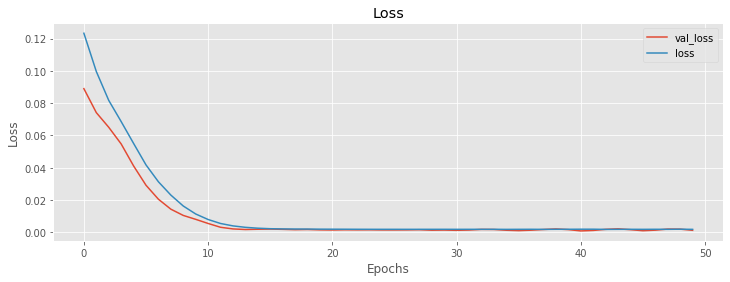

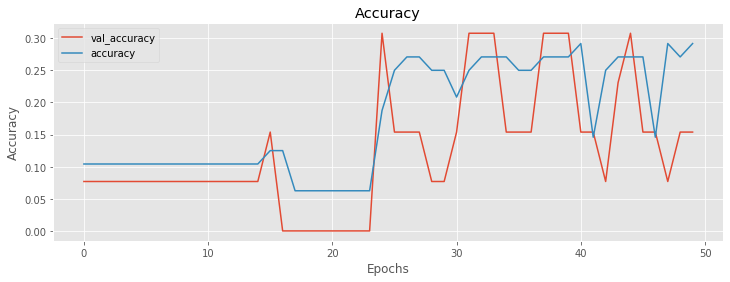

In [71]:
visualize_training_results(res)

Predicted Prices:
 [[0.5602185726165771], [0.5598613619804382], [0.5640403032302856], [0.5635243654251099], [0.5672620534896851], [0.5688517093658447], [0.5676230192184448], [0.56961590051651], [0.5698176622390747], [0.5698382258415222]]

Actual Prices:
 [[0.5251564099740714], [0.543639588941264], [0.5496498117192037], [0.5588610215233252], [0.5575196146111454], [0.5572916406437063], [0.5650435137649085], [0.5569647937094576], [0.5323256099416882], [0.5324737171976962]]


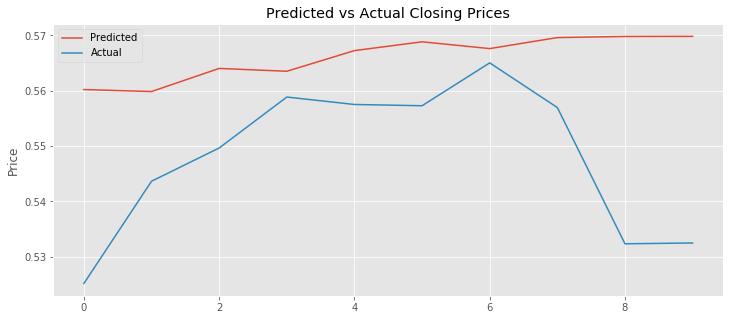

In [72]:
plt.figure(figsize=(12,5))

# Getting predictions by predicting from the last available X variable
yhat = model.predict(X[-1].reshape(1, n_per_in, n_features)).tolist()[0]

# Transforming values back to their normal prices
yhat = scaler.inverse_transform(np.array(yhat).reshape(-1,1)).tolist()

# Getting the actual values from the last available y variable which correspond to its respective X variable
actual = scaler.inverse_transform(y[-1].reshape(-1,1))

# Printing and plotting those predictions
print("Predicted Prices:\n", yhat)
plt.plot(yhat, label='Predicted')

# Printing and plotting the actual values
print("\nActual Prices:\n", actual.tolist())
plt.plot(actual.tolist(), label='Actual')

plt.title(f"Predicted vs Actual Closing Prices")
plt.ylabel("Price")
plt.legend()
#plt.savefig("BTC_validation.png")
plt.show()

               Close
2020-09-22  0.559669
2020-09-23  0.559648
2020-09-24  0.563478
2020-09-25  0.563154
2020-09-26  0.566712
2020-09-27  0.568453
2020-09-28  0.567383
2020-09-29  0.569344
2020-09-30  0.569155
2020-10-01  0.569501


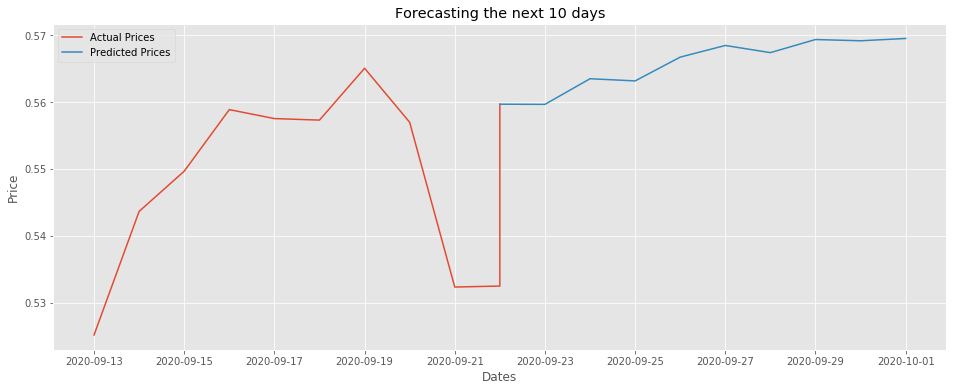

In [73]:
# Predicting off of y because it contains the most recent dates
yhat = model.predict(np.array(df.tail(n_per_in)).reshape(1, n_per_in, n_features)).tolist()[0]

# Transforming the predicted values back to their original prices
yhat = scaler.inverse_transform(np.array(yhat).reshape(-1,1)).tolist()

# Creating a DF of the predicted prices
preds = pd.DataFrame(yhat, index=pd.date_range(start=df.index[-1], periods=len(yhat), freq="D"), columns=df.columns)

# Printing the predicted prices
print(preds)

# Number of periods back to visualize the actual values
pers = 10

# Transforming the actual values to their original price
actual = pd.DataFrame(scaler.inverse_transform(df[["Close"]].tail(pers)), index=df.Close.tail(pers).index, columns=df.columns).append(preds.head(1))

# Plotting
plt.figure(figsize=(16,6))
plt.plot(actual, label="Actual Prices")
plt.plot(preds, label="Predicted Prices")
plt.ylabel("Price")
plt.xlabel("Dates")
plt.title(f"Forecasting the next {len(yhat)} days")
plt.legend()
#plt.savefig("BTC_predictions.png")
plt.show()